In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# 工程中使用的超参数

In [ ]:
"""
  是否固定随机数种子来保证算法的可复现
  注意会影响算法性能（由于其随机性减弱）
  这里取值42,是深度学习中常用的lucky number,
    来源于《银河系漫游指南》中的宇宙终极答案"42"
"""
np.random.seed(42)

In [ ]:
"""
  是否让算法运行中的更多细节打印在console
"""
# debug = True
debug = False
cntTime = False

In [ ]:
# 定义一个修饰器函数用来统计函数的运行时间
# 参考我的csdn  https://blog.csdn.net/prinTao/article/details/121800857?spm=1001.2014.3001.5501
import time
def timmer(func):    #传入的参数是一个函数
    def deco(*args, **kwargs): #本应传入运行函数的各种参数
      if cntTime:
        print('\n函数：{_funcname_}开始运行：'.format(_funcname_=func.__name__))
        start_time = time.time()#调用代运行的函数，并将各种原本的参数传入
        res = func(*args, **kwargs)
        end_time = time.time()
        print('函数:{_funcname_}运行了 {_time_}秒'
              .format(_funcname_=func.__name__, _time_=(end_time - start_time)))
        return res#返回值为函数
    return deco

# 测试样例函数定义

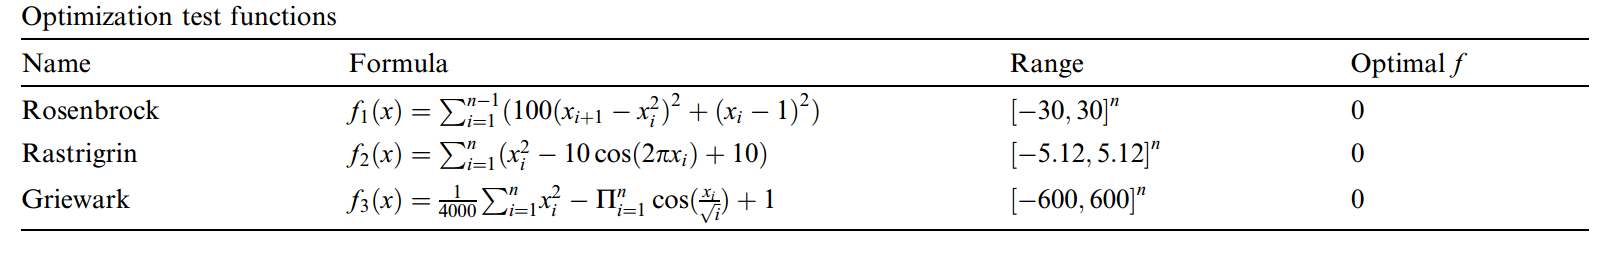

In [ ]:
def mid_Procedure(tmp):
  '''
    返回测试样例三中的连乘，使用lambda表达式返回的值是错的（没有找到原因）
    因此选用显式的函数来定义
  '''
  all = 1.0
  for i in range(1,len(tmp)+1):
    all = all * np.cos(tmp[i-1]/np.sqrt(i))
  return all

In [ ]:
x = np.random.uniform(-30, 30, (1, 10))
x

array([[ -7.52759287,  27.04285838,  13.91963651,   5.91950905,
        -20.63888157, -20.64032878, -26.51498327,  21.97056875,
          6.0669007 ,  12.48435467]])

In [ ]:
def get_Value(x,function='Rosenbrock'):
    '''计算拟合目标函数的值
    x
      当前位置
    function
      拟合的目标函数，使用多变数下的扩展(sum形式)
    '''
    if debug:
      print('输入到价值计算函数中的值',x)
    elif function=='Rosenbrock':
      # 这里需要错开一位
      return  sum(100*(x[0][1:] - x[0][:-1]** 2.0)**2.0 + (x[0][:-1]-1)**2.0)
    elif function=='Rastrigrin':
      return  sum(x[0][:-1]**2.0 + 10*np.cos(2*np.pi*x[0][:-1]) + 10)
    elif function=='Griewark':
      return  sum(1/4000*(x[0][:-1]**2.0)) + mid_Procedure(x[0][:-1]) + 1
    else:
      raise ValueError("输入目标函数未定义")
    #return sum(100.0 * (x[0][1:] - x[0][:-1] ** 2.0) ** 2.0 + (1 - x[0][:-1]) ** 2.0)

In [ ]:
# 测试样例
get_Value(x,function='Griewark'),'Rosenbrock','Rastrigrin','Griewark'

(1.7737406587484594, 'Rosenbrock', 'Rastrigrin', 'Griewark')

# 种群维护类

In [ ]:
class Particle:
    """种群类
    自身属性：
      位置    __location
      速度    __speed
      目标函数  __fitnessValue
    """
    def __init__(self, x_max, max_vel, dim, functype='Rosenbrock'):
        # 粒子的速度  1*dim的二位数组  
        self.__speed = np.random.uniform(-max_vel, max_vel, (1, dim)) 
        # 粒子的生成位置 1*dim的二位数组
        self.__location = np.random.uniform(-x_max, x_max, (1, dim))  
        # 粒子中最好的位置 
        self.__best_distribute = np.zeros((1, dim))  
        # 适应度函数值
        self.__fitnessValue = get_Value(self.__location,functype)
        # 算法样例的维度 
        self.__dimention = dim
    def renew_all(self):
        """
          clear all the buffer in this class 
        """
        # 粒子的速度  1*dim的二位数组  
        self.__speed = np.zeros((1, self.__dimention))  
        # 粒子的生成位置 1*dim的二位数组
        self.__location = 0  
        # 粒子中最好的位置 
        self.__best_distribute = 0 
        # 适应度函数值
        self.__fitnessValue = 0

    # 按python规定，private变量需要使用函数访问
    def set_pos(self, value):
        self.__location = value
    def set_vel(self, value):
        self.__speed = value
    def set_best_pos(self, value):
        self.__best_distribute = value
    def get_vel(self):
        return self.__speed
    def set_fitness_value(self, value):
        self.__fitnessValue = value
    def get_fitness_value(self):
        return self.__fitnessValue
    def get_pos(self):
        return self.__location
    def get_best_pos(self):
        return self.__best_distribute


# PSO算法类

## 速度变换公式：
$v_{i+1}=w*v_i+c_1*rand_1*(pbest_i-x_i)+c_2*rand_2*(gbest_i-x_i) vi+1​=w∗vi​+c1​∗rand1​∗(pbesti​−xi​)+c2​∗rand2​∗(gbesti​−xi​) $  
## 位置变换公式：
$ x_i=x_i+v_{i+1}   ;   x_i​=x_i​+v_i+1 ​$

## Notation:
w为惯性因子，一般取1   
$c_1,c_2$​为学习因子，一般取2   
$rand_1,rand_2$为（0，1）之间的随机数  
$v_i和x_i $​分别表示粒子第i维的速度和位置  
$pbest_i,gbest_i$分别表示某个粒子最好位置第i维的值，整个种群最好位置第i维的值


In [ ]:
class PSO:
    '''PSO算法执行
    超参数和中间参数:
      注释写在旁边了
    '''
    def __init__(self, dim, size, iter_num, x_max, max_vel, tol, best_fitness_value=float('Inf'), C1=2, C2=2, W=1, aiming_func='Rosenbrock'):
        """超参数"""
        self.C1 = C1                  # 学习因子，默认为2
        self.C2 = C2                  # 学习因子，默认为2
        self.W = W                   # 惯性因子，默认1
        self.dim = dim                 # 粒子的维度
        self.size = size                # 粒子个数
        self.iter_num = iter_num            # 迭代次数
        self.x_max = x_max               # 位置限制，绝定生成x的范围
        self.max_vel = max_vel             # 移动最大速度
        self.tol = tol                 # 算法停止误差限
        """中间参数"""
        self.best_fitness_value = best_fitness_value  # 最优值
        self.best_position = np.zeros((1, dim))    # 种群最优位置
        self.fitness_val_list = []           # 迭代中间结果（画图）
        self.func_type = aiming_func          # 目标函数选取

        """算法搜索区域限制"""
        if aiming_func=='Rosenbrock':
          self.x_max = 30
        elif aiming_func == 'Rastrigrin':
          self.x_max = 5.12
        elif aiming_func == 'Griewark':
          self.x_max = 600

        # 种群进行初始化
        self.Particle_list = [Particle(self.x_max, self.max_vel, self.dim, self.func_type) for i in range(self.size)]

    def set_bestFitnessValue(self, value):
        self.best_fitness_value = value
    def get_bestFitnessValue(self):
        return self.best_fitness_value
    def set_bestPosition(self, value):
        self.best_position = value
    def get_bestPosition(self):
        return self.best_position

    def update_vel(self, this_slice):
        """更新速度方法
        公式在上面
        """
        # 更新速度（矢量意义的）
        vel_value = self.W * this_slice.get_vel() + self.C1 * np.random.rand() * (this_slice.get_best_pos() - this_slice.get_pos()) \
                    + self.C2 * np.random.rand() * (self.get_bestPosition() - this_slice.get_pos())
        # 选取速度中大于速度阈值上限的，截断设为最高速度
        vel_value[vel_value > self.max_vel] = self.max_vel
        # 选取速度中小于速度阈值下限的，截断设为最低速度
        vel_value[vel_value < -self.max_vel] = -self.max_vel
        # 保存本轮速度
        this_slice.set_vel(vel_value)

    def update_pos(self, this_slice):
        """位置更新方法
        公式在上面
        """
        # 离散的积分，上一位置加当前速度
        pos_value = this_slice.get_pos() + this_slice.get_vel()
        # 写入类内变量
        this_slice.set_pos(pos_value)
        # 输入测试样例方程，获取本轮搜索结果
        value = get_Value(this_slice.get_pos())
        # 判断这次的结果和此切片中的最好的哪个更好
        if value < this_slice.get_fitness_value():
            # 更新本轮种群最好结果和最优值
            this_slice.set_fitness_value(value)
            this_slice.set_best_pos(pos_value)
        # 判断这次的结果和全局最好的哪个更好
        if value < self.get_bestFitnessValue():
            # 更新全局最好结果和最优值
            self.set_bestFitnessValue(value)
            self.set_bestPosition(pos_value)
    
    # 使用迭代器测量时间 会导致其不可迭代
    #timmer
    def update_ndim(self):
        for i in tqdm(range(self.iter_num)):
            # 从种群列表中截取一个slice
            for this_slice in self.Particle_list:
                # 更新速度
                self.update_vel(this_slice)
                # 更新位置  
                self.update_pos(this_slice) 
            # 在训练过程保存列表中加上本轮结果，便于可视化 
            self.fitness_val_list.append(self.get_bestFitnessValue())  # 每次迭代完把当前的最优适应度存到列表
            # 通过debug超参数决定是否打印详细情况
            if i%10 == 0 and debug:
              print('第{}次最佳适应值为{}'.format(i, self.get_bestFitnessValue()))
            # 算法提前停止准则
            if self.get_bestFitnessValue() < self.tol:
                # 循环没必要继续了
                # print("early stop")
                break

        return self.fitness_val_list, self.get_bestPosition()

In [ ]:
# 测试函数
fit_var_list = [100.10000,1]
fit_var_list = np.array(fit_var_list)
np.log10(fit_var_list)

array([2.00043408, 0.        ])

In [ ]:
# 转换对数坐标，方便观察较大差距情况下下降的情况
def graph_log_axis(fit_var_list,set1='',set2='',changes=''):
  # 防止传入的是list，转一次numpy
  fit_var_list = np.array(fit_var_list)
  fit_var_list = np.log10(fit_var_list)
  plt.xlabel('iter times')
  plt.ylabel('log(Value)')
  plt.title(set1+' '+set2)
  x_pow = list(range(0,len(fit_var_list)))
  plt.plot(x_pow, fit_var_list, label=changes)
  plt.legend()

# 对比实验

In [ ]:
# 转换对数坐标，方便观察较大差距情况下下降的情况
# 改进为整体绘图
def graph_log_axis(fit_var_list,set1='',set2='',changes=''):
  fit_var_list = np.array(fit_var_list)
  fit_var_list = np.log10(fit_var_list)
  #fit_var_list = np.log10(fit_var_list)
  plt.xlabel('iter times')
  plt.ylabel('log(Value)')
  plt.title(set1+' '+set2)
  x_pow = list(range(0,len(fit_var_list)))
  plt.plot(x_pow, fit_var_list, label=changes, alpha=0.6)
  plt.legend()

## 小图展示

100%|██████████| 1000/1000 [00:01<00:00, 605.73it/s]


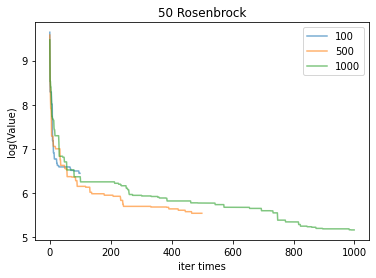

100%|██████████| 1000/1000 [00:03<00:00, 305.54it/s]


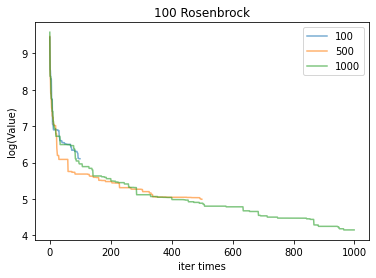

100%|██████████| 1000/1000 [00:09<00:00, 100.19it/s]


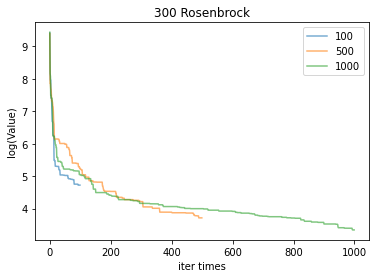

100%|██████████| 1000/1000 [00:01<00:00, 612.03it/s]


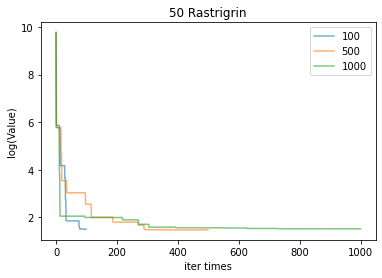

100%|██████████| 1000/1000 [00:03<00:00, 304.27it/s]


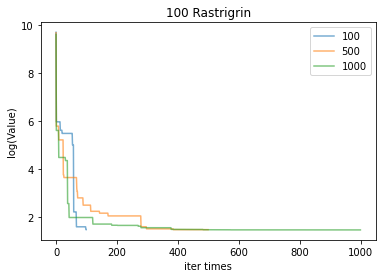

100%|██████████| 1000/1000 [00:09<00:00, 100.06it/s]


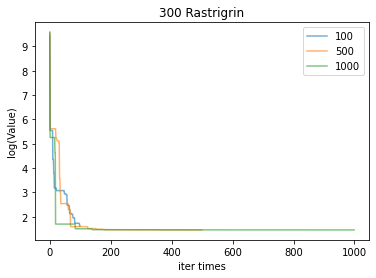

100%|██████████| 1000/1000 [00:01<00:00, 611.65it/s]


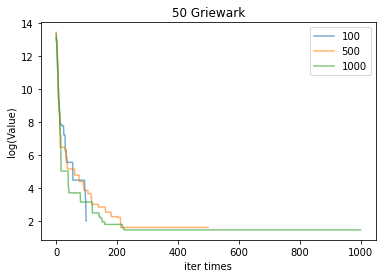

100%|██████████| 1000/1000 [00:03<00:00, 305.23it/s]


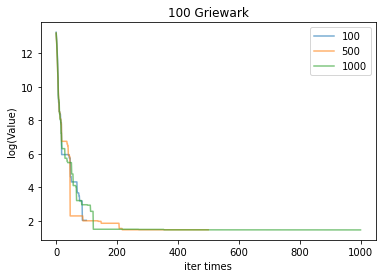

100%|██████████| 1000/1000 [00:10<00:00, 99.64it/s]


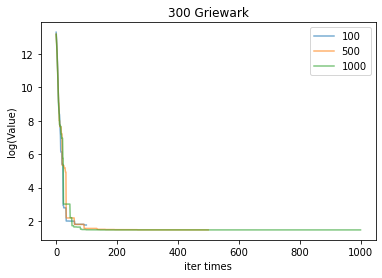

In [ ]:
# test 香蕉函数 Rosenbrock
for func in ['Rosenbrock','Rastrigrin','Griewark']:
  for num in [50,100,300]:
    for iter in [100,500,1000]:
      pso = PSO(30, num, iter, 30, 60, 1e-4, C1=2, C2=2, W=1, aiming_func=func)
      fit_var_list, best_pos = pso.update_ndim()
      if debug:
        print("最优位置:" + str(best_pos))
        print("最优解:" + str(fit_var_list[-1]))
      graph_log_axis(fit_var_list,str(num),func,str(iter))
      #plt.plot(range(len(fit_var_list)), fit_var_list, alpha=0.5)
    plt.show() 
  

## 迭代次数（iter num）的对照试验

100%|██████████| 1000/1000 [00:09<00:00, 100.02it/s]


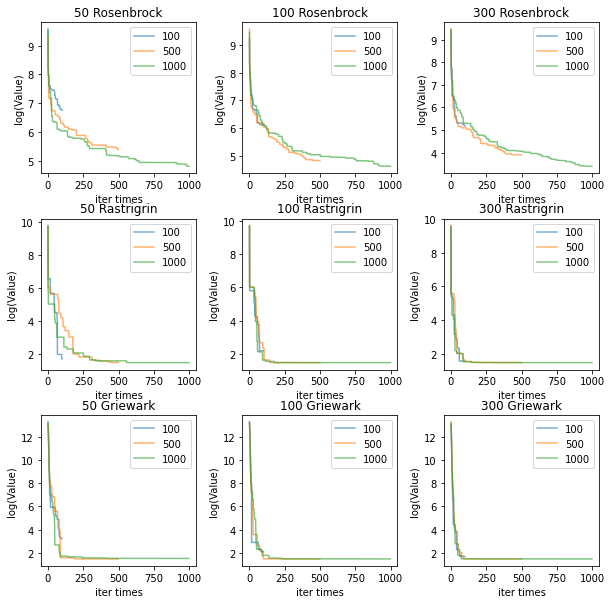

In [ ]:
# 迭代次数对照试验
fig = plt.figure(figsize=(10,10))
x=0;y=0
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3,hspace=0.3)
for func in ['Rosenbrock','Rastrigrin','Griewark']:
  x=x+1
  for num in [50,100,300]:
    y=y+1
    plt.subplot(3,3,y)
    # ax = fig.add_subplot(3,3,y)
    for iter in [100,500,1000]:
      pso = PSO(30, num, iter, 30, 60, 1e-4, C1=2, C2=2, W=1, aiming_func=func)
      fit_var_list, best_pos = pso.update_ndim()
      graph_log_axis(fit_var_list,str(num),func,str(iter))
      #plt.plot(range(len(fit_var_list)), fit_var_list, alpha=0.5)
plt.show() 

## 三种函数的实验

100%|██████████| 1000/1000 [00:09<00:00, 100.36it/s]


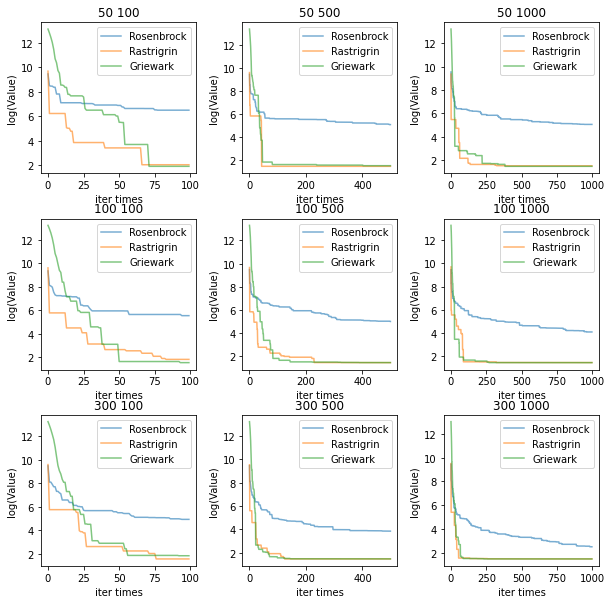

In [ ]:
fig = plt.figure(figsize=(10,10))
x=0;y=0
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3,hspace=0.3)
for num in [50,100,300]:
  x=x+1
  for iter in [100,500,1000]:
    y=y+1
    plt.subplot(3,3,y)
    # ax = fig.add_subplot(3,3,y)
    
    for func in ['Rosenbrock','Rastrigrin','Griewark']:
      pso = PSO(30, num, iter, 30, 60, 1e-4, C1=2, C2=2, W=1, aiming_func=func)
      fit_var_list, best_pos = pso.update_ndim()
      graph_log_axis(fit_var_list,str(num),str(iter),func)
      #plt.plot(range(len(fit_var_list)), fit_var_list, alpha=0.5)
plt.show() 

## 种群数量的实验

100%|██████████| 1000/1000 [00:09<00:00, 111.09it/s]


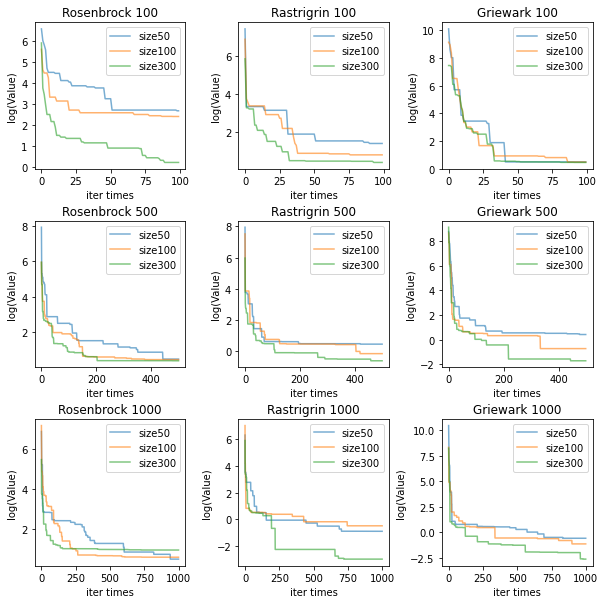

In [ ]:
# 创建大图
fig = plt.figure(figsize=(10,10))
x=0;y=0
# 调整间距
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.35,hspace=0.35)
iter_list = [100,500,1000]
func_list = ['Rosenbrock','Rastrigrin','Griewark']
num_list  = [50,100,300]
for iter in iter_list: 
  for func in func_list:
    y=y+1
    # 新建子图 从1开始i
    plt.subplot(3,3,y)
    # ax = fig.add_subplot(3,3,y)
    for num in num_list:
      pso = PSO(4, num, iter, 30, 60, 1e-4, C1=2, C2=2, W=1, aiming_func=func)
      fit_var_list, best_pos = pso.update_ndim()
      graph_log_axis(fit_var_list,func,str(iter),'size'+str(num))
      #plt.plot(range(len(fit_var_list)), fit_var_list, alpha=0.5)
plt.show() 

# 探究学习因子和动量超参数的对算法的影响

100%|██████████| 500/500 [00:04<00:00, 112.03it/s]


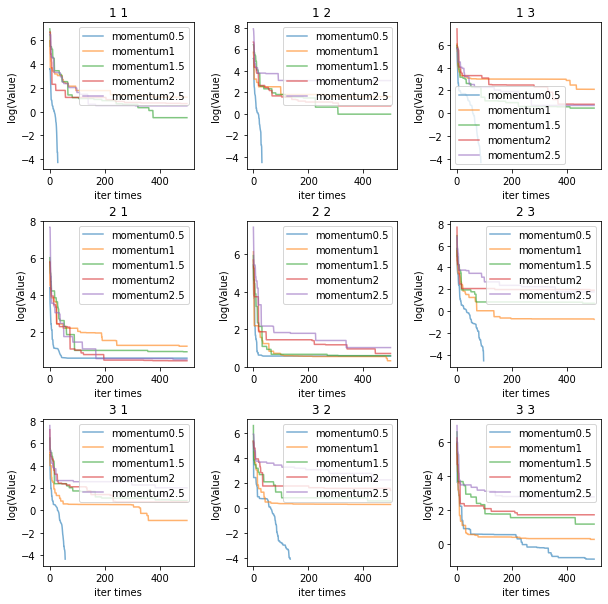

In [ ]:
# 创建大图
fig = plt.figure(figsize=(30,30))
y=0
# 调整间距
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.35,hspace=0.35)
iter_list = [1000]
func_list = ['Rosenbrock','Rastrigrin','Griewark']
num_list  = [300]
C1_list = list(range(1,4))
C2_list = list(range(1,4))
W_list = [0.5,1,1.5,2,2.5]
# 图的数量
pic_x = len(C1_list)
pic_y = len(C2_list)

for this_C1 in C1_list: 
  for this_C2 in C2_list:
    y=y+1
    # 新建子图 从1开始i
    plt.subplot(pic_x,pic_y,y)
    for this_W in W_list:
      pso = PSO(4, 300, 500, 30, 60, 1e-4, C1=this_C1, 
                C2=this_C2, W=this_W, aiming_func='Rosenbrock')
      fit_var_list, best_pos = pso.update_ndim()
      graph_log_axis(fit_var_list,str(this_C1),str(this_C2),'momentum'+str(this_W))
      #plt.plot(range(len(fit_var_list)), fit_var_list, alpha=0.5)
plt.show() 

100%|██████████| 500/500 [00:04<00:00, 110.52it/s]


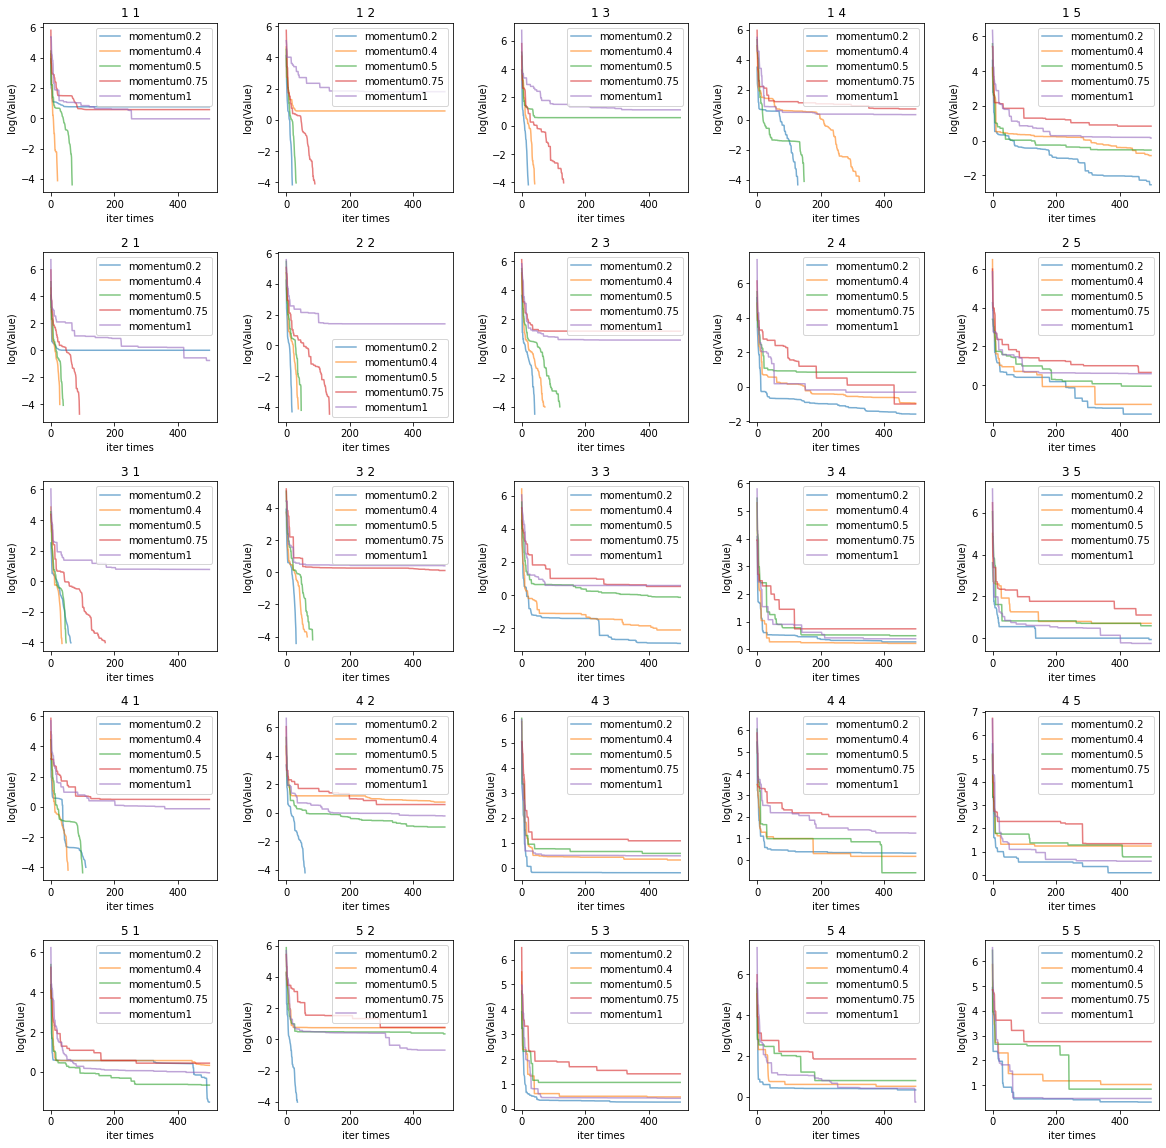

In [ ]:
# 创建大图
fig = plt.figure(figsize=(20,20))
y=0
# 调整间距
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.35,hspace=0.35)
iter_list = [1000]
func_list = ['Rosenbrock','Rastrigrin','Griewark']
num_list  = [300]
C1_list = list(range(1,6))
C2_list = list(range(1,6))
W_list = [0.2,0.4,0.5,0.75,1]
# 图的数量
pic_x = len(C1_list)
pic_y = len(C2_list)

for this_C1 in C1_list: 
  for this_C2 in C2_list:
    y=y+1
    # 新建子图 从1开始i
    plt.subplot(pic_x,pic_y,y)
    for this_W in W_list:
      pso = PSO(4, 300, 500, 30, 60, 1e-4, C1=this_C1, 
                C2=this_C2, W=this_W, aiming_func='Rosenbrock')
      fit_var_list, best_pos = pso.update_ndim()
      graph_log_axis(fit_var_list,str(this_C1),str(this_C2),'momentum'+str(this_W))
      #plt.plot(range(len(fit_var_list)), fit_var_list, alpha=0.5)
plt.show() 

In [ ]:
[x*0.1 for x in range(1,10) ]

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]

In [ ]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

100%|██████████| 500/500 [00:04<00:00, 110.59it/s]


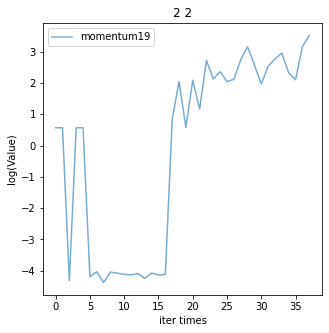

In [ ]:
# 创建大图
fig = plt.figure(figsize=(5,5))
y=0
# 调整间距
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.35,hspace=0.35)
iter_list = [1000]
func_list = ['Rosenbrock','Rastrigrin','Griewark']
num_list  = [300]
C1_list = list(range(1,6))
C2_list = list(range(1,6))
W_list = [x*0.05 for x in range(1,20) ] +[x*1 for x in range(1,20) ] 
# 图的数量
pic_x = len(C1_list)
pic_y = len(C2_list)
this_C2 = 2
this_C1 =2

total = []
for this_W in W_list:
  pso = PSO(4, 300, 500, 30, 60, 1e-4, C1=this_C1, 
            C2=this_C2, W=this_W, aiming_func='Rosenbrock')
  fit_var_list, best_pos = pso.update_ndim()
  total.append(fit_var_list[-1])
  # graph_log_axis(fit_var_list,str(this_C1),str(this_C2),'momentum'+str(this_W))
  #plt.plot(range(len(fit_var_list)), fit_var_list, alpha=0.5)
graph_log_axis(total,str(this_C1),str(this_C2),'momentum'+str(this_W))

In [ ]:
best_pos,fit_var_list[-1]

(array([[ 0.2836115 ,  0.13338197, -0.01638501,  0.04269839]]),
 2.8744389216404596)

In [ ]:
# 检查cpu
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

# 算法改进


In [83]:
class PSO:
    '''PSO算法执行
    超参数和中间参数:
      注释写在旁边了
    '''
    def __init__(self, dim, size, iter_num, x_max, max_vel, tol, best_fitness_value=float('Inf'), C1=2, C2=2, W=1, aiming_func='Rosenbrock'):
        """超参数"""
        self.C1 = C1                  # 学习因子，默认为2
        self.C2 = C2                  # 学习因子，默认为2
        self.W = W                   # 惯性因子，默认1
        self.dim = dim                 # 粒子的维度
        self.size = size                # 粒子个数
        self.iter_num = iter_num            # 迭代次数
        self.x_max = x_max               # 位置限制，绝定生成x的范围
        self.max_vel = max_vel             # 移动最大速度
        self.tol = tol                 # 算法停止误差限
        """中间参数"""
        self.best_fitness_value = best_fitness_value  # 最优值
        self.best_position = np.zeros((1, dim))    # 种群最优位置
        self.fitness_val_list = []           # 迭代中间结果（画图）
        self.func_type = aiming_func          # 目标函数选取
        self.cnt_iter = 0               ## 记录当前迭代次数
        self.W_now = W                 # 记录当前W参数

        """算法搜索区域限制"""
        if aiming_func=='Rosenbrock':
          self.x_max = 30
        elif aiming_func == 'Rastrigrin':
          self.x_max = 5.12
        elif aiming_func == 'Griewark':
          self.x_max = 600

        # 种群进行初始化
        self.Particle_list = [Particle(self.x_max, self.max_vel, self.dim, self.func_type) for i in range(self.size)]

    def set_bestFitnessValue(self, value):
        self.best_fitness_value = value
    def get_bestFitnessValue(self):
        return self.best_fitness_value
    def set_bestPosition(self, value):
        self.best_position = value
    def get_bestPosition(self):
        return self.best_position
    def W_decay_refresh(self,method='sqrt'):
      """动量衰减策略维护函数
      nowIter
        当前迭代轮数
      maxIter
        预计总迭代次数
      maxLR
        学习率
      method
        梯度下降策略，比如余弦退火、平方、线性等
      """
      minLR = 3 # 最低返回学习率，截断
      nowIter = self.cnt_iter
      maxIter = self.iter_num
      maxLR = self.W
      LR = maxLR
      if method == 'sqrt':
        LR = int( (1 - nowIter/maxIter*nowIter/maxIter)*maxLR )
        if LR<minLR:
          LR=minLR
      
      elif method == 'linear':
        LR = int( (1 - nowIter/maxIter)*maxLR )
        if LR<minLR:
          LR=minLR

      self.W_now = LR

    def update_vel(self, this_slice):
        """更新速度方法
        公式在上面
        """
        self.W_decay_refresh('sqrt')
        # 更新速度（矢量意义的）
        vel_value = self.W_now * this_slice.get_vel() + self.C1 * np.random.rand() * (this_slice.get_best_pos() - this_slice.get_pos()) \
                    + self.C2 * np.random.rand() * (self.get_bestPosition() - this_slice.get_pos())
        # 选取速度中大于速度阈值上限的，截断设为最高速度
        vel_value[vel_value > self.max_vel] = self.max_vel
        # 选取速度中小于速度阈值下限的，截断设为最低速度
        vel_value[vel_value < -self.max_vel] = -self.max_vel
        # 保存本轮速度
        this_slice.set_vel(vel_value)

    def update_pos(self, this_slice):
        """位置更新方法
        公式在上面
        """
        # 离散的积分，上一位置加当前速度
        pos_value = this_slice.get_pos() + this_slice.get_vel()
        # 写入类内变量
        this_slice.set_pos(pos_value)
        # 输入测试样例方程，获取本轮搜索结果
        value = get_Value(this_slice.get_pos())
        # 判断这次的结果和此切片中的最好的哪个更好
        if value < this_slice.get_fitness_value():
            # 更新本轮种群最好结果和最优值
            this_slice.set_fitness_value(value)
            this_slice.set_best_pos(pos_value)
        # 判断这次的结果和全局最好的哪个更好
        if value < self.get_bestFitnessValue():
            # 更新全局最好结果和最优值
            self.set_bestFitnessValue(value)
            self.set_bestPosition(pos_value)
    
    # 使用迭代器测量时间 会导致其不可迭代
    def update_ndim(self):
        for i in tqdm(range(self.iter_num)):
            # 从种群列表中截取一个slice
            for this_slice in self.Particle_list:
                # 更新速度
                self.update_vel(this_slice)
                # 更新位置  
                self.update_pos(this_slice) 
            # 在训练过程保存列表中加上本轮结果，便于可视化 
            self.fitness_val_list.append(self.get_bestFitnessValue())  # 每次迭代完把当前的最优适应度存到列表
            # 通过debug超参数决定是否打印详细情况
            if i%10 == 0 and debug:
              print('第{}次最佳适应值为{}'.format(i, self.get_bestFitnessValue()))
            # 算法提前停止准则
            if self.get_bestFitnessValue() < self.tol:
                # 循环没必要继续了
                # print("early stop")
                break
            self.cnt_iter = self.cnt_iter + 1
        return self.fitness_val_list, self.get_bestPosition()

100%|██████████| 1000/1000 [00:11<00:00, 90.88it/s]


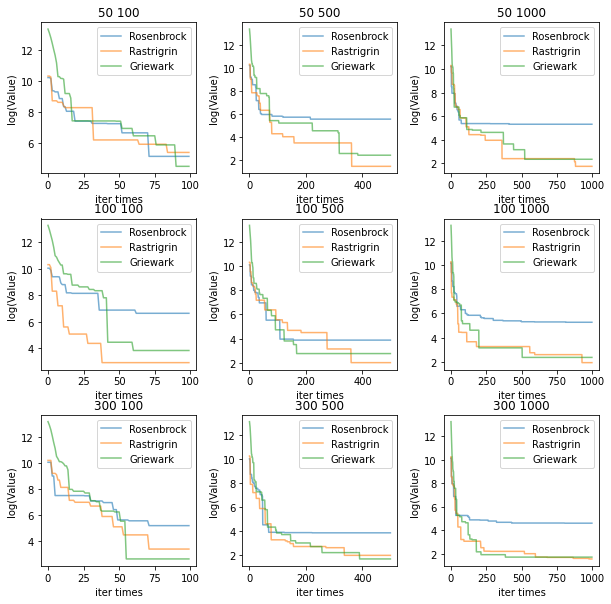

In [84]:
fig = plt.figure(figsize=(10,10))
x=0;y=0
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3,hspace=0.3)
for num in [50,100,300]:
  x=x+1
  for iter in [100,500,1000]:
    y=y+1
    plt.subplot(3,3,y)
    # ax = fig.add_subplot(3,3,y)
    
    for func in ['Rosenbrock','Rastrigrin','Griewark']:
      pso = PSO(30, num, iter, 30, 60, 1e-4, C1=2, C2=2, W=1, aiming_func=func)
      fit_var_list, best_pos = pso.update_ndim()
      graph_log_axis(fit_var_list,str(num),str(iter),func)
      #plt.plot(range(len(fit_var_list)), fit_var_list, alpha=0.5)
plt.show() 